# Compare different hydrological set-ups
All model runs were run with free-draining conditions and conditions that allowed higher groundwater tables. Eventually the parameters of the two set-ups were also switched in order to check the influence of the hydrological set-up on the fluxes. 


## Ensemble years
Ensemble years were calculated for the free-draining and dynamic water-tables set-up, for each value of the cost factor for water transport cpcff.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, date
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from scipy.misc import imread
import matplotlib.cbook as cbook

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


No handles with labels found to put in legend.


not found


No handles with labels found to put in legend.


not found


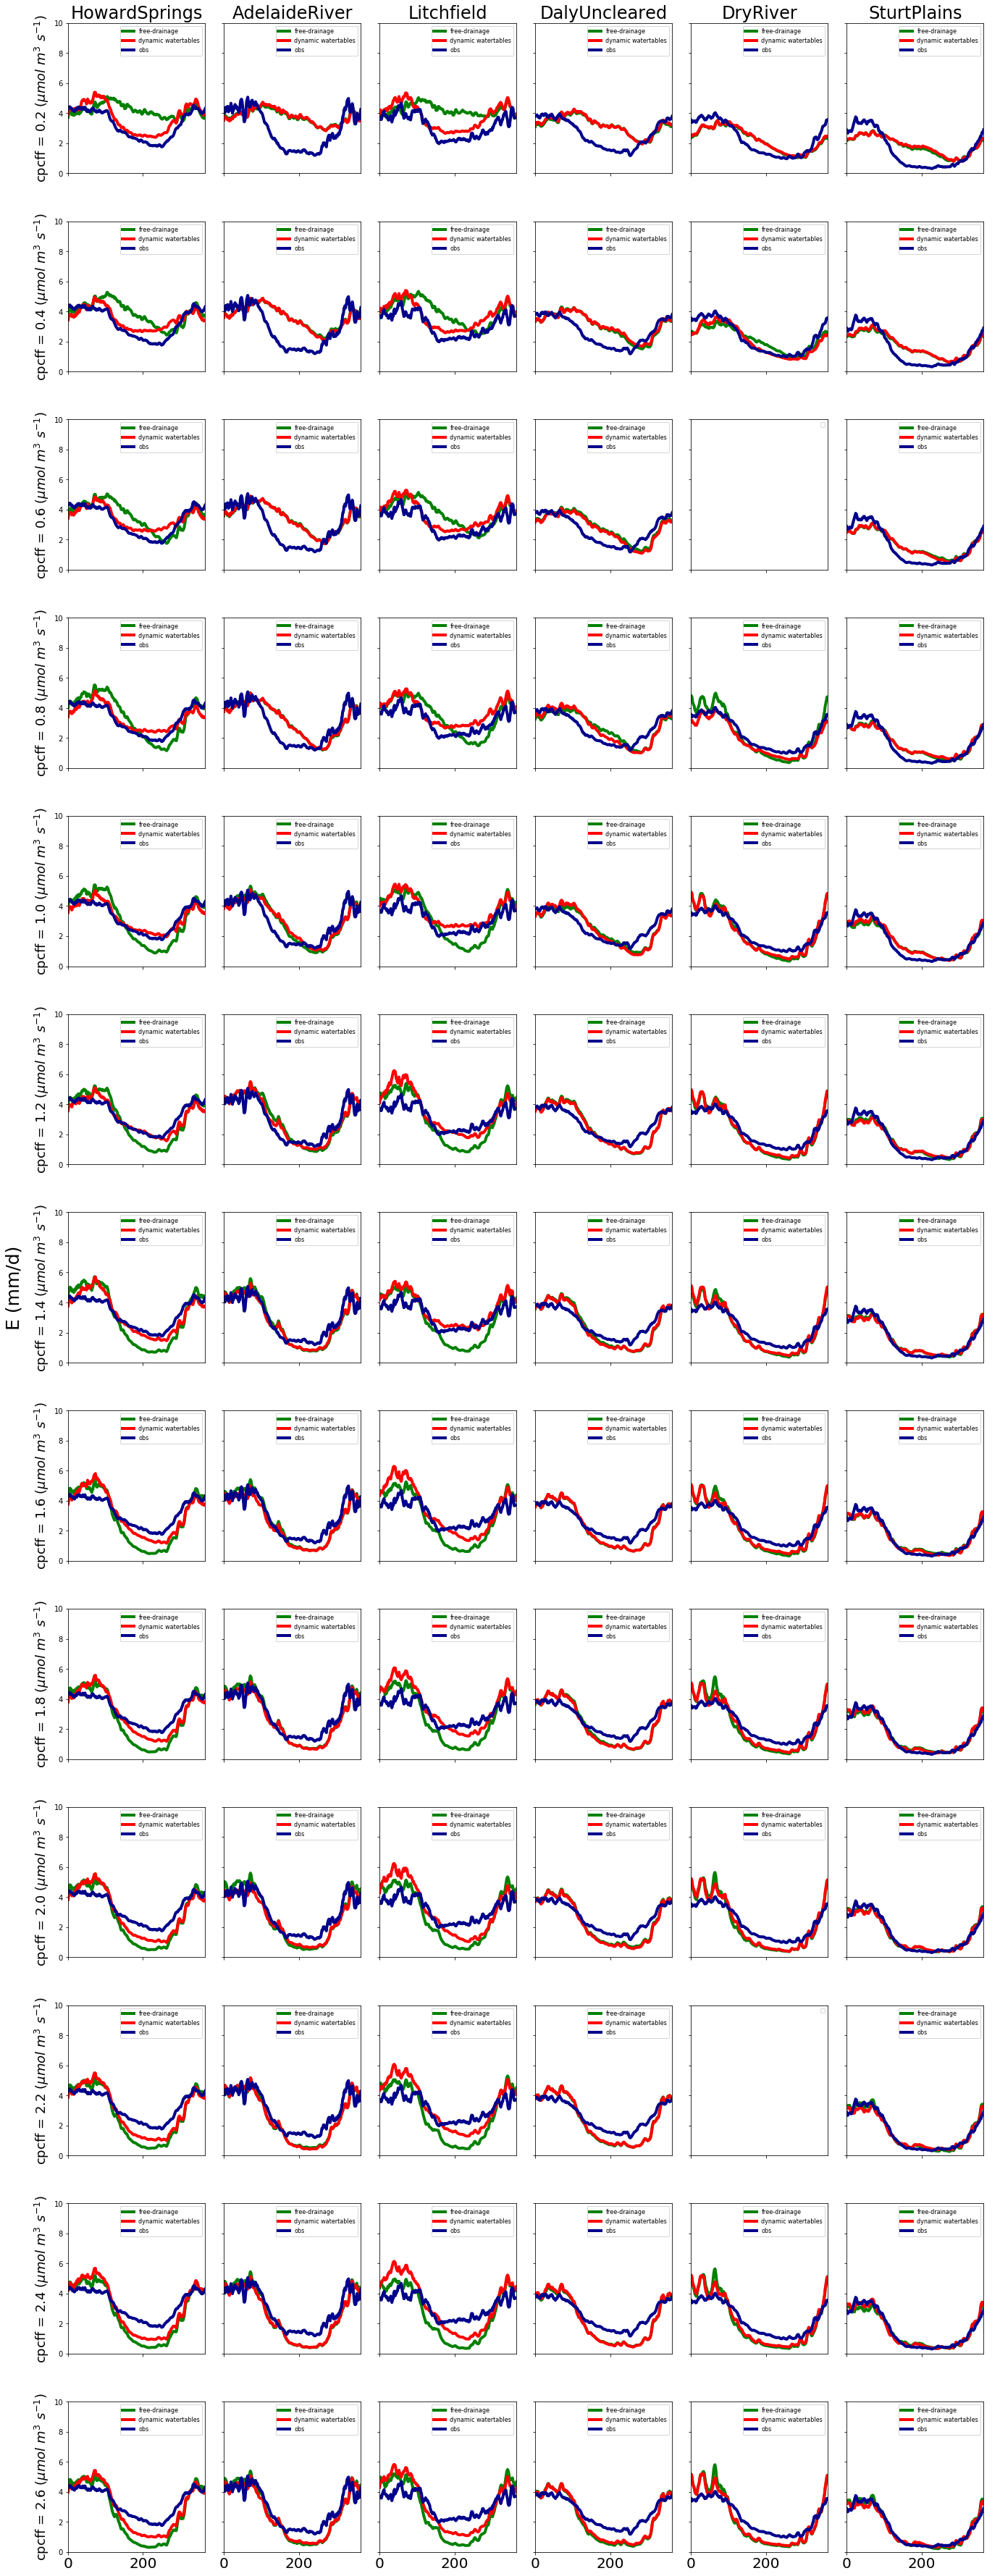

In [3]:
#ensemble year

i_site = 0
basin = ["HowardSprings", "AdelaideRiver", "Litchfield", "DalyUncleared", "DryRiver",  "SturtPlains"]
basin_short = ["howard","adelaide","litch", "daly",  "dry",  "sturt"]


cpcff_vals = np.arange(0.2,2.8, 0.2)
cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)


plt.rcParams['xtick.labelsize'] = 20
fig, ax   = plt.subplots(nrows=13, ncols=6, figsize=(20, 50), sharex=True, sharey=True ) 

icol = 0
irow = 0

for ibasin in  np.arange(0,6):  
    
    #load fluxtower observations
    ea_tmp = np.loadtxt("../../data/DINGO/Ea_"+ basin_short[ibasin] +".txt", usecols=2) #mm/d
    tobs =  np.genfromtxt("../../data/DINGO/Ea_"+ basin_short[ibasin] +".txt",usecols=0, dtype=np.str )#mm/d
    tobs= pd.date_range(tobs[0], tobs[-1], freq='D')
    
    DOY = tobs.dayofyear
    eo_ens = np.zeros([366])
    
    #calculate ensemble for fluxtowers
    for iday in range(0,366):
        eo_ens[iday] = np.mean( ea_tmp[DOY == (iday+1)]  )  #mm/d
       
    #loop over cpcff-values
    for cpcff in cpcff_str:

        try:
            #load data free-draining conditions
            inputfile = "../../data/VOM_output/"+ basin[ibasin] + "/freedrainage_cpcff" + cpcff + "/sce_best/results_daily.txt"  
            data1 = np.genfromtxt(inputfile, names=True)

            #load data dynamic watertables
            inputfile = "../../data/VOM_output/" + basin[ibasin] + "/nofreedrainage_cpcff" + cpcff + "/sce_best/results_daily.txt"
            data2 = np.genfromtxt(inputfile, names=True)

            #calculate total evaporation
            e1 = data1["esoil"] + data1["etmt"] + data1["etmg"]
            e2 = data2["esoil"] + data2["etmt"] + data2["etmg"]

            #define timeseries
            tmod1 = pd.date_range( data1["fyear"][0] + data1["fmonth"][0]  + data1["fday"][0], freq = "D", periods = len(e1))
            tmod2 = pd.date_range( data2["fyear"][0] + data2["fmonth"][0]  + data1["fday"][0], freq = "D", periods = len(e2))


            #empty arrays for ensemble years
            e_ens1 = np.zeros([366])
            e_ens2 = np.zeros([366])
            e7d1 = np.zeros([367])
            e7d2 = np.zeros([367])
            eo7d = np.zeros([367]) #observed

            #use last 10 years for ensembles
            tmp1 = e1[-3650:]
            tmp2 = e2[-3650:]

            DOY = tmod1.dayofyear[0:len(tmp1)] 
            DOY = DOY[-3650:]
            for iday in range(0,366):
                e_ens1[iday] = np.mean( tmp1[DOY == (iday+1)]  ) * 1000 #mm/d
                e_ens2[iday] = np.mean( tmp2[DOY == (iday+1)]  ) * 1000 #mm/d

            #7-day running mean
            N = 7
            for iday in range(0,367):
                if iday > (366-N):
                    e7d1[iday]  = np.mean( np.concatenate( (e_ens1[iday:366], e_ens1[0:(N-(366-iday))] )) )
                    e7d2[iday]  = np.mean( np.concatenate( (e_ens2[iday:366], e_ens2[0:(N-(366-iday))] )) )
                    eo7d[iday]  = np.mean( np.concatenate( (eo_ens[iday:366], eo_ens[0:(N-(366-iday))] )) )
                else:    
                    e7d1[iday] = np.mean(e_ens1[iday:(iday+N)])
                    e7d2[iday] = np.mean(e_ens2[iday:(iday+N)])
                    eo7d[iday] = np.mean(eo_ens[iday:(iday+N)])

            ax[irow, icol].plot(range(0,367), e7d1, color = "green", linewidth=4, label = "free-drainage")
            ax[irow, icol].plot(range(0,367), e7d2, color="red", linewidth=4, label="dynamic watertables")
            ax[irow, icol].plot(range(0,367), eo7d, color="darkblue", linewidth=4, label = "obs")
        except OSError:
            print("not found")
            
        #ax0.set(ylabel = r'Residuals Et ( $\sigma_{ET} $  )', xlabel = '' )
        #ax0.set_xlim([datetime(year[ibasin],1, 1), datetime( year[ibasin] ,12, 31)])  
        ax[irow, icol].set_ylim([ 0, 10 ])
        ax[irow, icol].set_xlim([ 0, 366 ])  

        
        if(irow == 0):
            ax[irow, icol].set_title(basin[ibasin], fontsize = 24)
        
        #ax[irow, icol].set_xlabel('DOY' , size=18   )
    
        #for tick in ax[irow, icol].xaxis.get_major_ticks():
        #    tick.label.set_fontsize(24)
        #for tick in ax[irow, icol].yaxis.get_major_ticks():
        #    tick.label.set_fontsize(24)

        ax[irow, icol].legend(prop={'size':8})
        if(icol == 0):
            ax[irow, icol].set_ylabel( r'cpcff = ' + cpcff  +' ($\mu$$mol$ $m^3$ $s^{-1}$)', fontsize=18)
        irow = irow + 1
    

        
    icol = icol + 1
    irow = 0 
    
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("E (mm/d)", size = 25, labelpad=40)

plt.tight_layout()
plt.show()



In [31]:
cpcff_vals

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6])

In [6]:
ax[10,8]

IndexError: index 8 is out of bounds for axis 1 with size 6

/home/remko/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


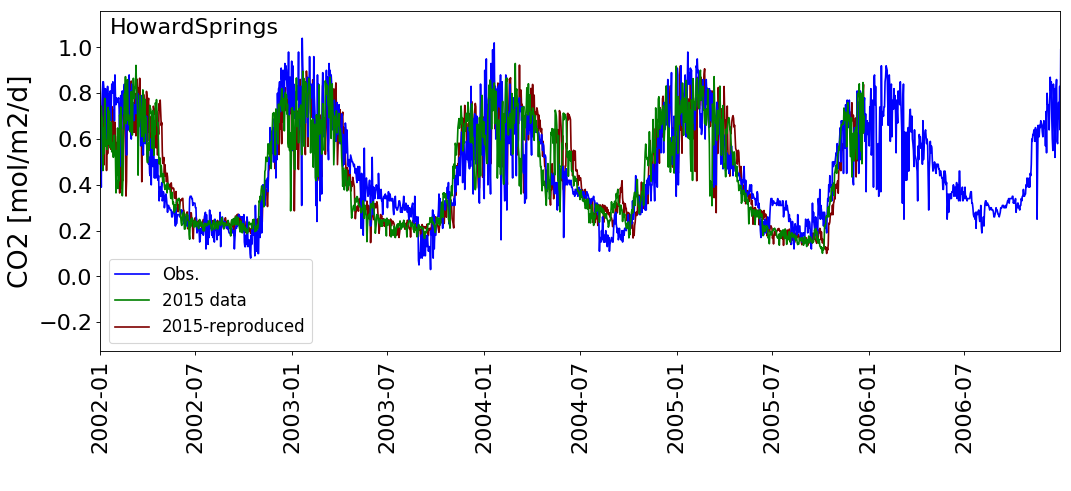

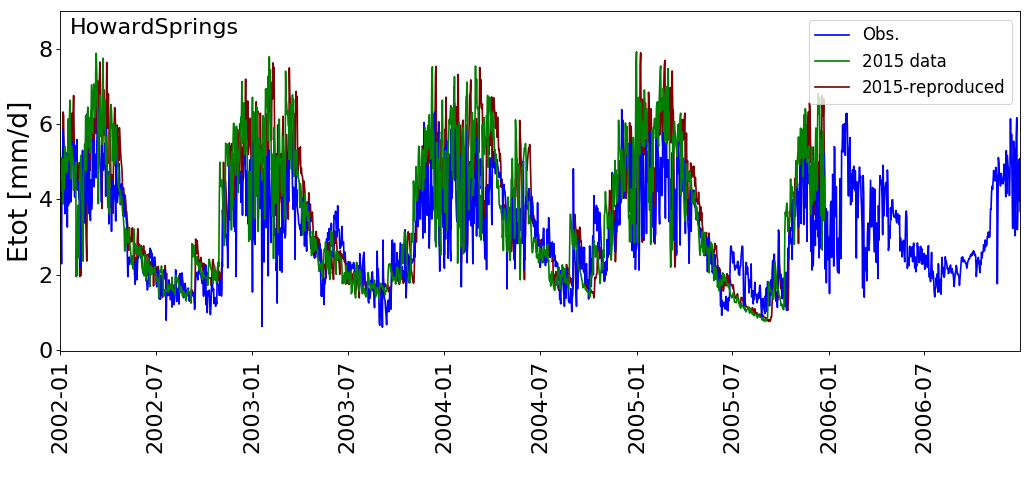

In [2]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/1_benchmark_repr/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels 2015-reproduced --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/1_benchmark_repr/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels 2015-reproduced --title "HowardSprings" --legend True




The results for assimilation and evaporation are the same, as expected, except for a small shift due to un-even years, that were not accounted for in the original data.

## Repeat SCE
SCE was repeated with the settings and parameterization of Schymanski et al. (2015), to check if it still converges towards similar results.

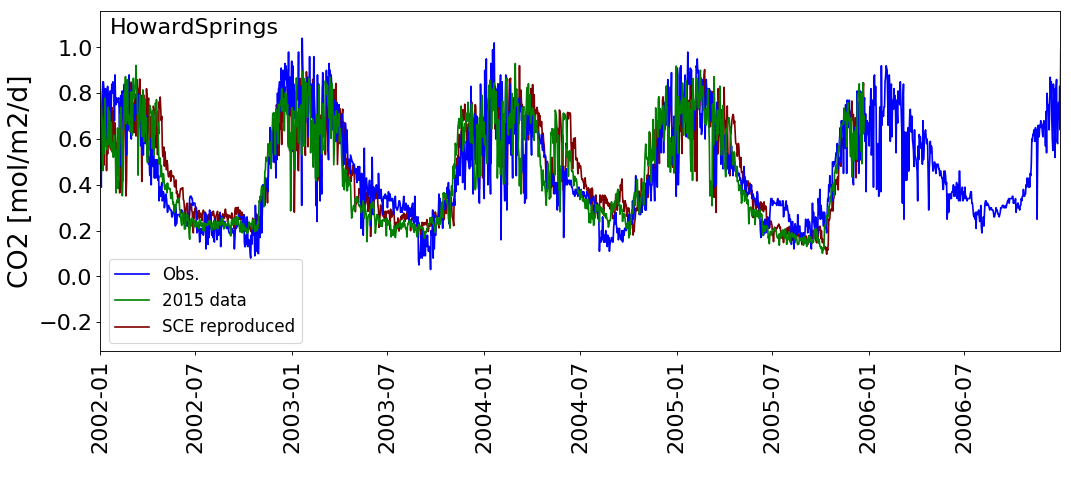

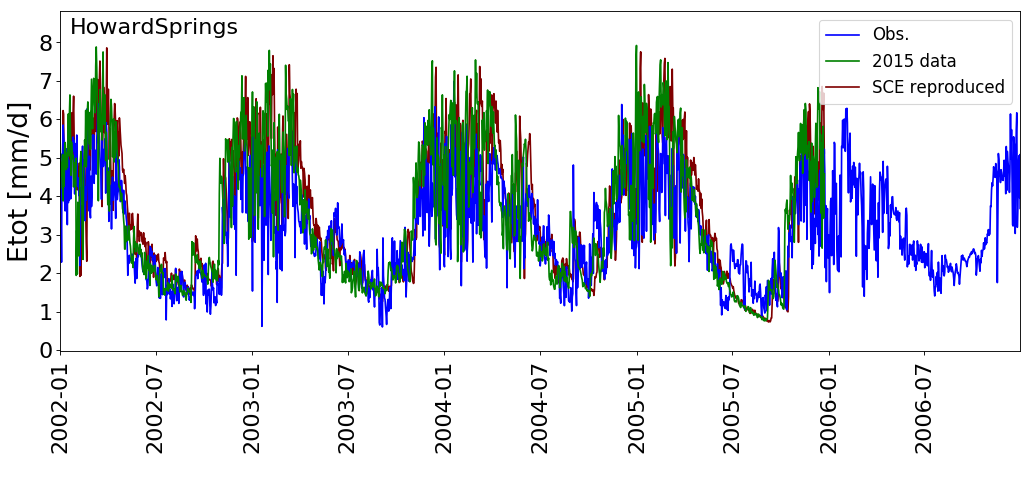

In [3]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/2_sce_check/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "SCE reproduced" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/2_sce_check/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "SCE reproduced" --title "HowardSprings" --legend True

The results for assimilation and evaporation are still rather similar after re-running SCE, only a shift due to un-even years remains. 

## Change of modelling period
Schymanski et al. (2015) modelled from 1976 untill 2005, the new runs start from 1980 untill 2017. 


In [4]:
#results still on HPC

#HowardSprings
#%run ../../src_py/plot_et_ass.py  \
#--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
##-i ../../data/VOM_output/additional_analyses/comp2015/3_modeltime/sce_best/results_daily.txt \
#-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
#--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
#--labels "SCE reproduced" --title "HowardSprings" --legend True

#%run ../../src_py/plot_et_ass.py  \
#--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
#-i ../../data/VOM_output/additional_analyses/comp2015/3_modeltime/sce_best/results_daily.txt \
#-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
#--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "CO2 [mol/m2/d]" \
#--labels "SCE reproduced" --title "HowardSprings" --legend True

## Change of atmospheric $CO_2$-values
Previously, atmospheric $CO_2$-values were fixed at 317ppm. The new runs use the MaunaLoa-records as input and have therefore variable $CO_2$-levels.


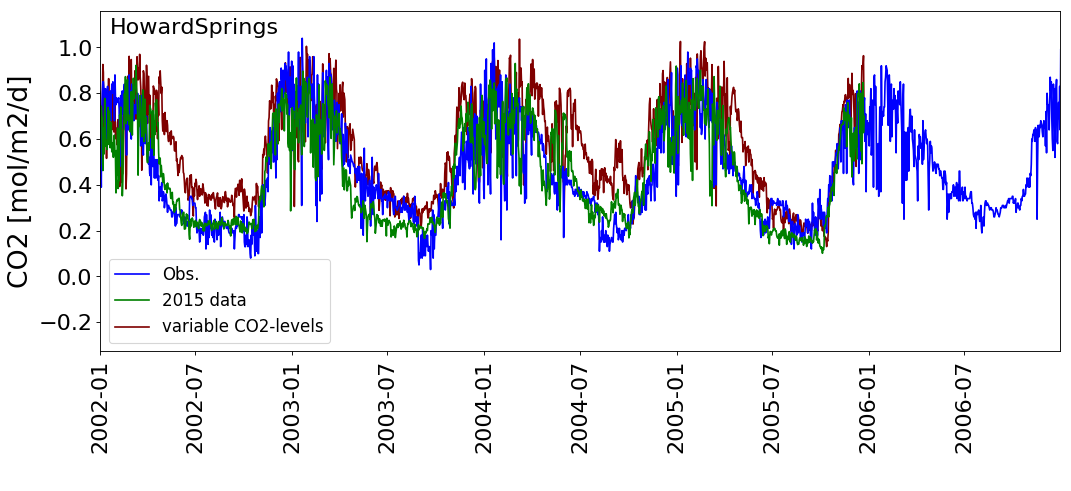

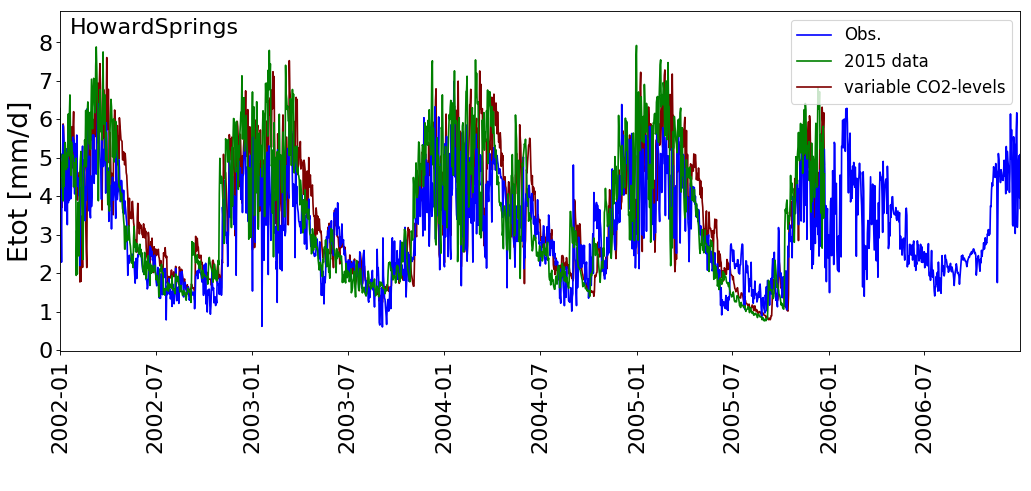

In [5]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/4_co2_var/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "variable CO2-levels" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/4_co2_var/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "variable CO2-levels" --title "HowardSprings" --legend True

There are several differences in the declining limbs of the curves, especially for assimilation. The values for atmospheric $CO_2$-levels are generally higher, leading to higher values of assimilation. The results for evaporation do not show such big differences.

## Change of soil layer thickness
Previously, the soil layer thickness was set at 0.5m, but the new runs use a soil layer thickness of 0.2m.


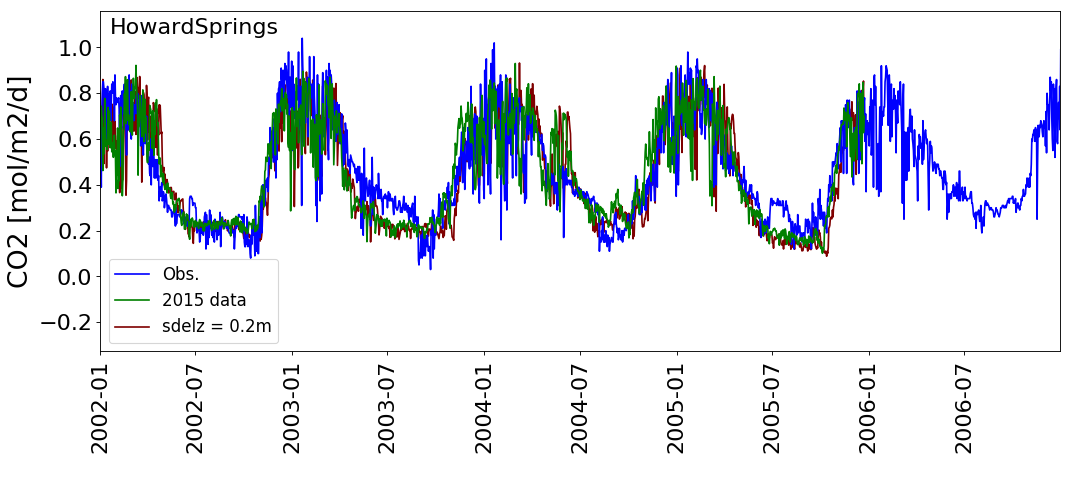

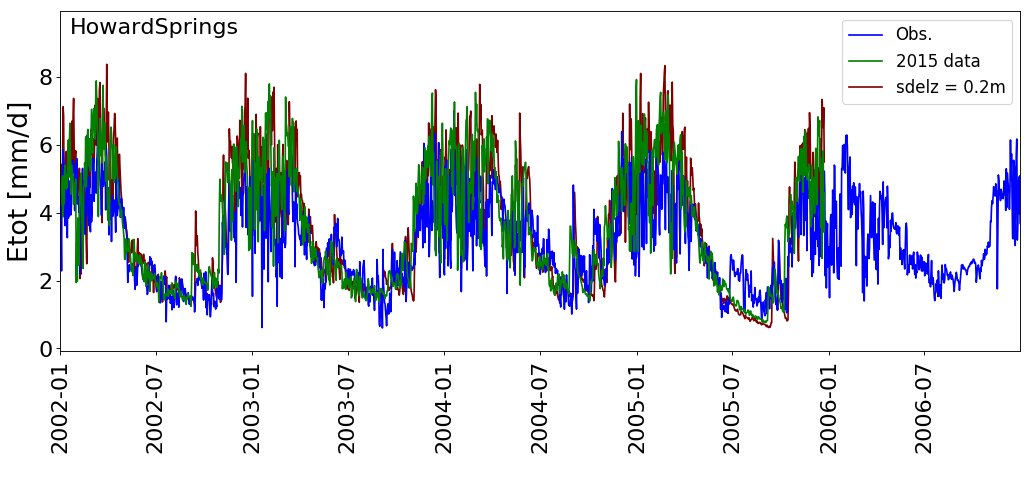

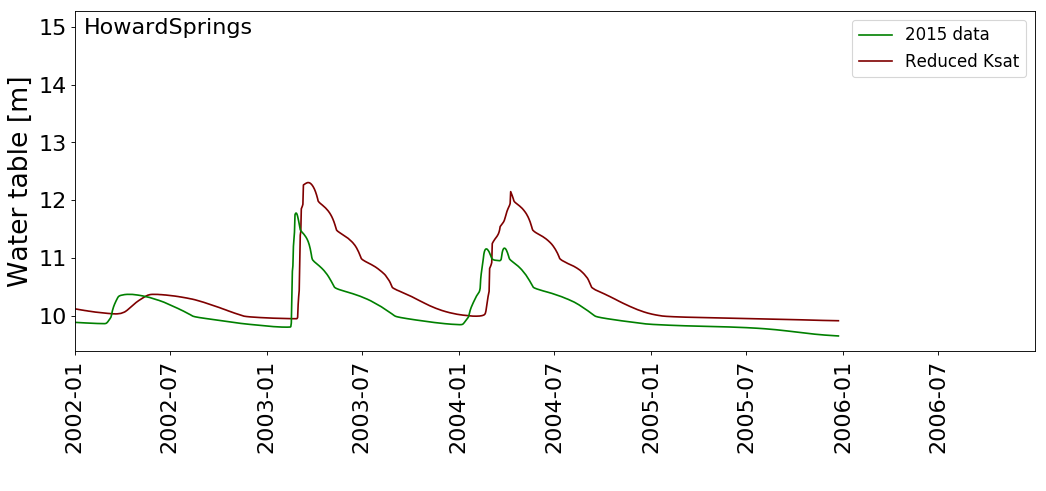

In [6]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/5_sdelz/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "sdelz = 0.2m" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/5_sdelz/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "sdelz = 0.2m" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/12_soil/sce_best/results_daily.txt \
-v zw --var2015 ys -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--ylabel "Water table [m]" \
--labels "Reduced Ksat" --title "HowardSprings" --legend True

The results for evaporation and assimilation have differences, but the differences are generally small. 

## Change of atmosperic pressures
Previously, the atmosperic pressure was fixed at 1013.25 hPa. The new runs use variable levels obtained from the SILO meteorological data.


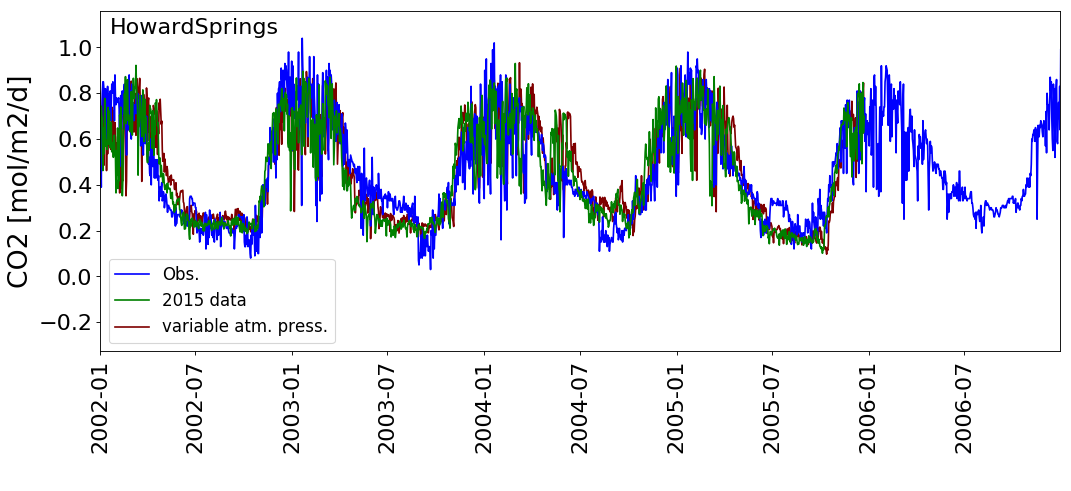

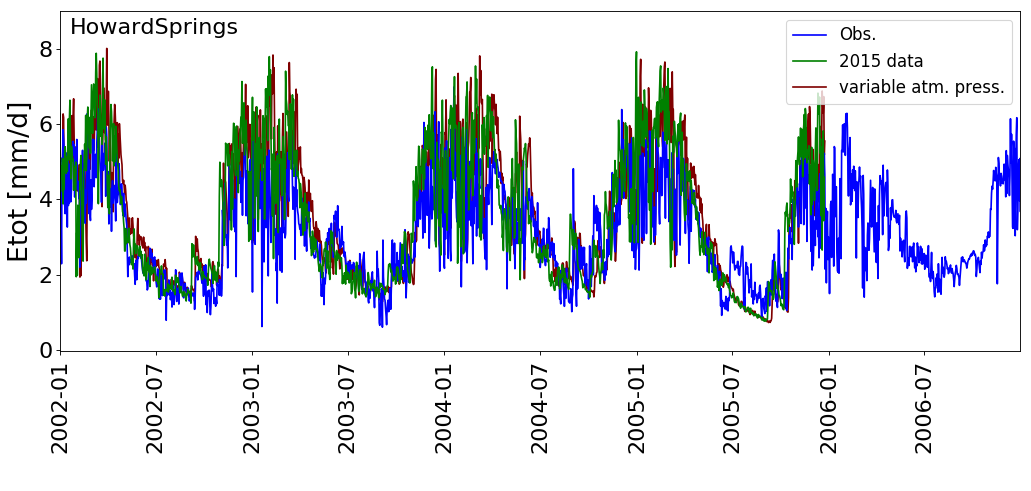

In [7]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/6_atm/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "variable atm. press." --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/6_atm/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "variable atm. press." --title "HowardSprings" --legend True

Evaporation and assimilation differ in details with the results from 2015. The effect of a variable atmospheric pressure seems not to be very strong, as the variability could also be caused by a slightly different result from the SCE-algorithm.

## Rooting depth grass as optimizable property
The new runs also optimize the rooting depth of grasses, which was previously fixed at 1.0m depth.

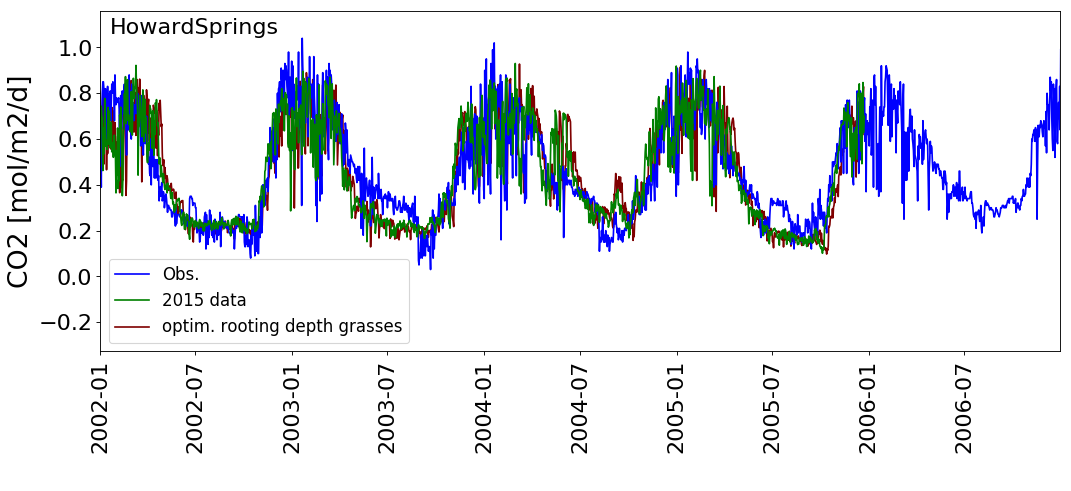

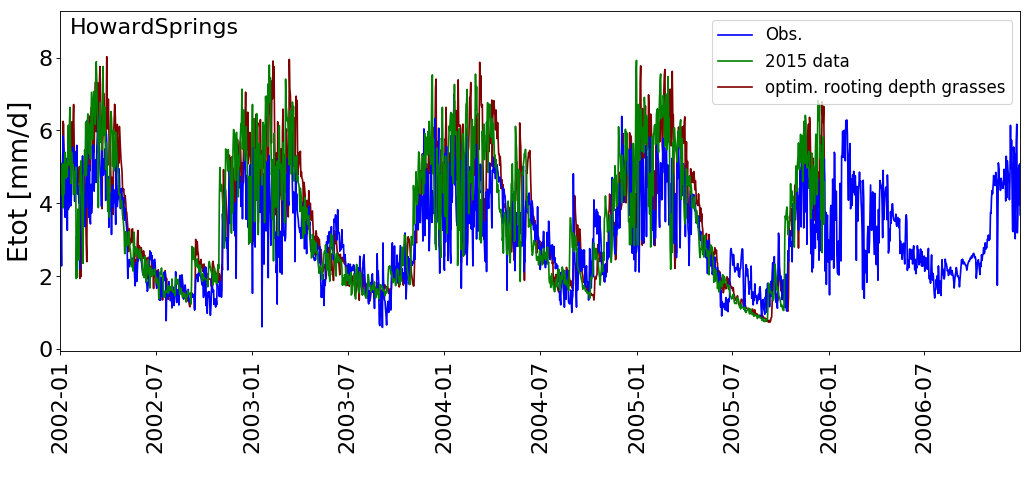

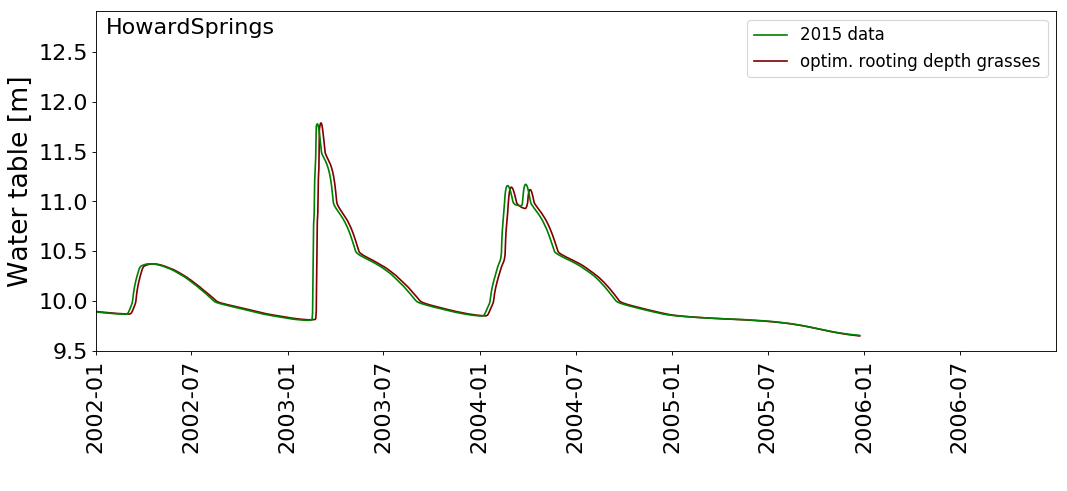

In [8]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/7_rgdepth/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "optim. rooting depth grasses" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/7_rgdepth/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "optim. rooting depth grasses" --title "HowardSprings" --legend True


%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/7_rgdepth/sce_best/results_daily.txt \
-v zw --var2015 ys -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--ylabel "Water table [m]" \
--labels "optim. rooting depth grasses" --title "HowardSprings" --legend True



The results for the fluxes are rather similar eventually, but the final rooting depths are different. In the new runs, rooting depth for grasses goes to 0.5m and 4m for trees, whereas the old runs used 1.0m for grasses and converged to 4.2m for trees.

## Costfactor for water transport capacity
The costfactor for water transport capacity used to be set at 1.0 $\mu mol/m3/s$, but is set to 1.2 $\mu mol/m3/s$.

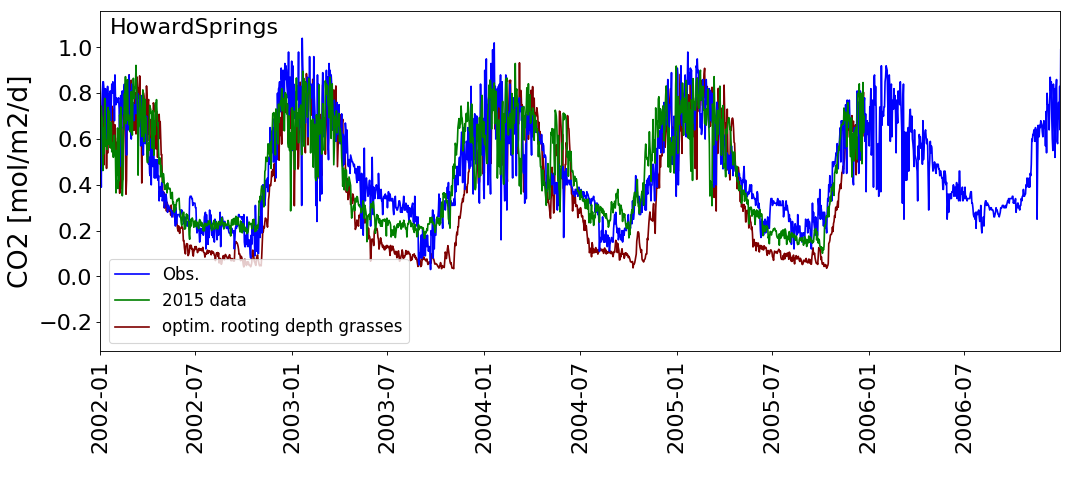

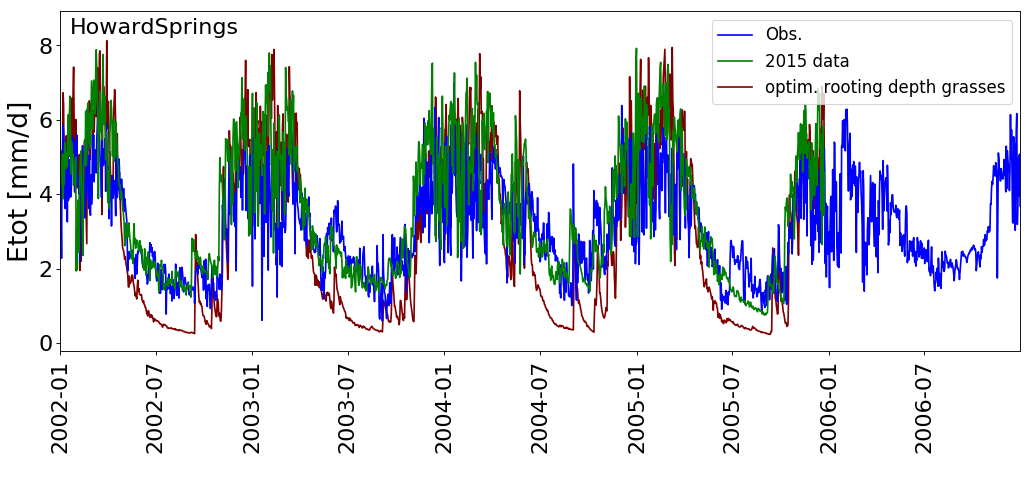

In [9]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/8_cpcff/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "optim. rooting depth grasses" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/8_cpcff/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "optim. rooting depth grasses" --title "HowardSprings" --legend True

There is a strong difference in the two model runs with different values for the costfactor for water transport (cpcff). Especially during the wet period the values for assimilation and evaporation are much smaller.

## Weatherdata
The weatherdata was updated with a new version of SILO-datadrill, also the atmosperic levels and CO$_2$-levels are changed in these runs.

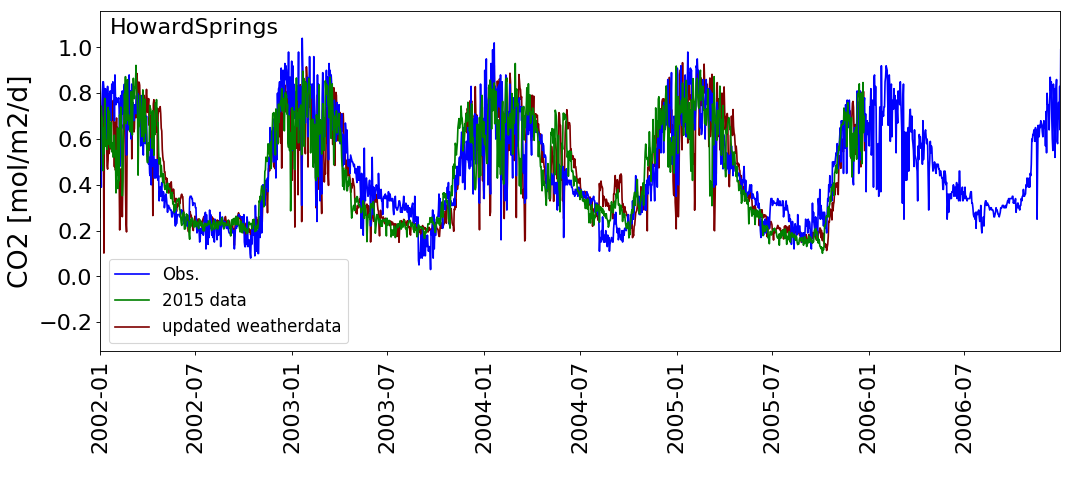

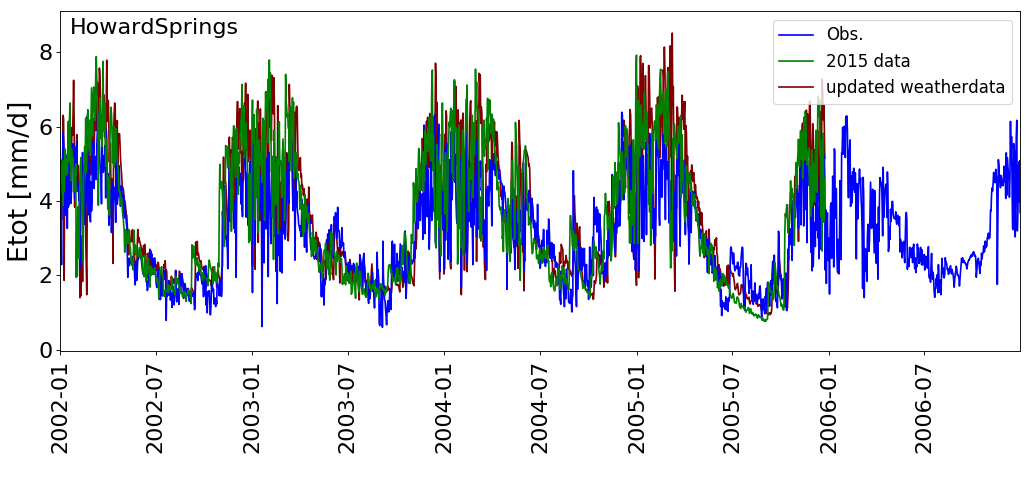

In [10]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/9_weather/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "updated weatherdata" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/9_weather/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "updated weatherdata" --title "HowardSprings" --legend True

## New hydrological formulation -  free draining conditions
The hydrology was previously defined as a soil block. In these runs, the hydrological set-up was chosen in a way that free-draining conditions were created. This was done by setting the total soil depth to 30 meters, with a short hydrological length scale (set to 2m).

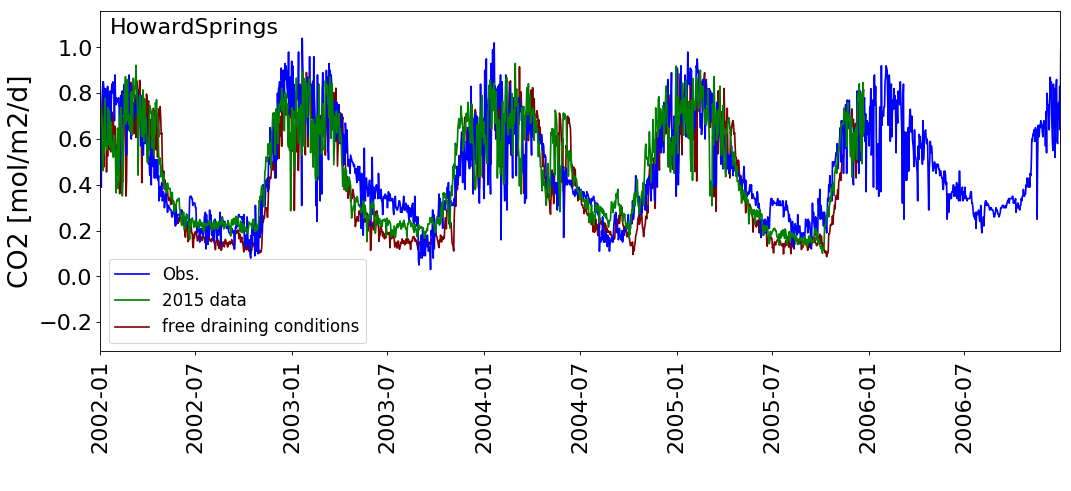

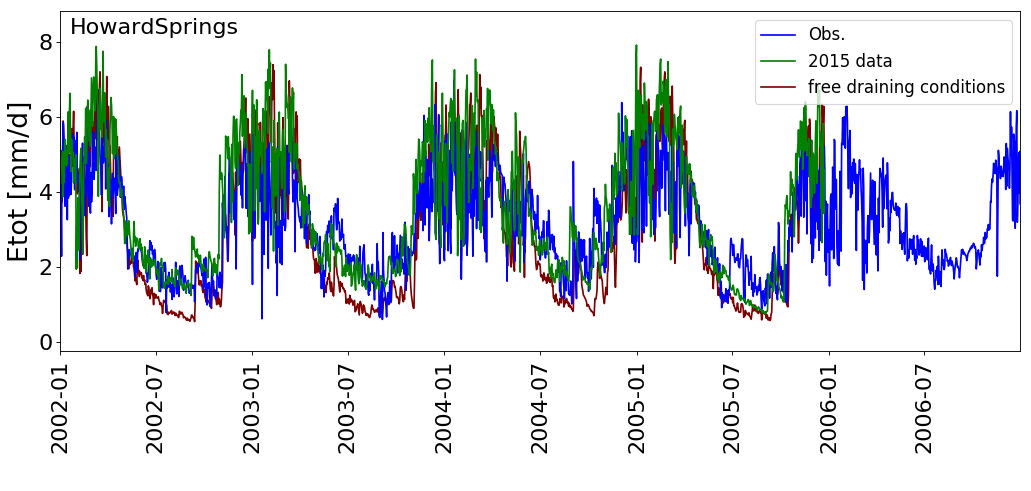

In [11]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/10_hydro1/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "free draining conditions" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/10_hydro1/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "free draining conditions" --title "HowardSprings" --legend True

Especially the evaporation seems to be different in the new set-up. Previously, higher groundwater tables were maintained and the evaporation during the wet period was higher.

## New hydrological set-up - dynamic water tables

The hydrology was previously defined as a soil block. In these runs, the hydrological set-up was chosen in a way that higher groundwater tables would be maintainedm which was based on the topography.

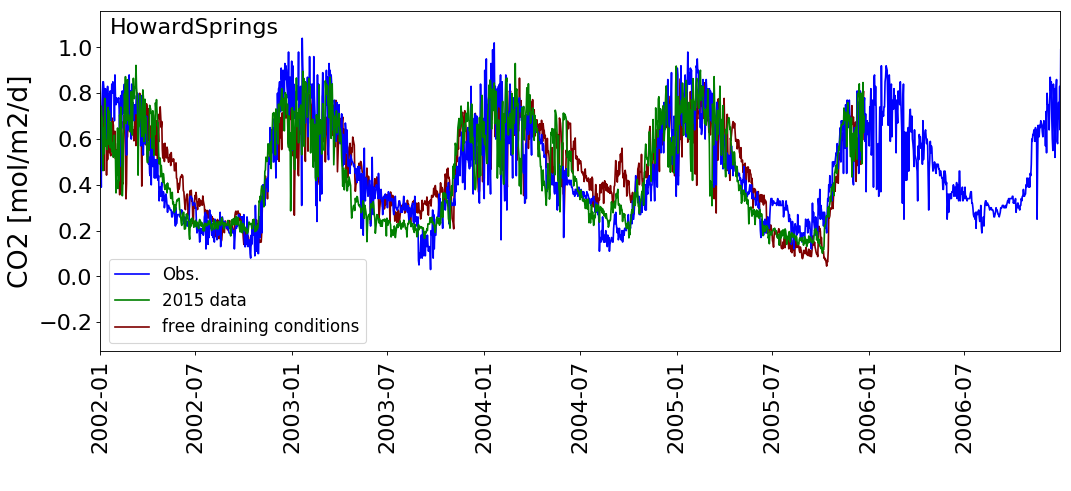

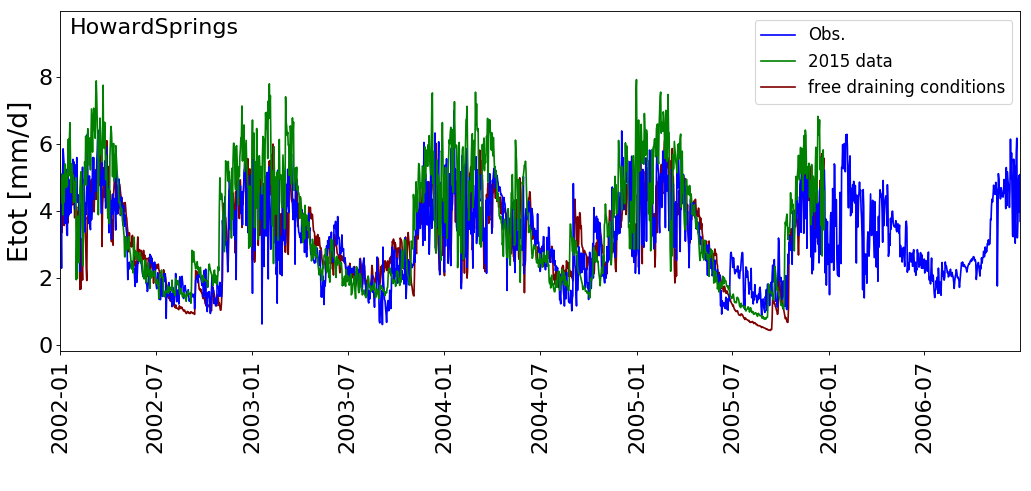

In [12]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/11_hydro2/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "free draining conditions" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/11_hydro2/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "free draining conditions" --title "HowardSprings" --legend True


These conditions seem to results which are closer to the previous set-up of the VOM, but differences still occur during the wet period.

## Changing soil parameters
Hydraulic conductivity for the new runs was set to $2.5 10^{-6} m/s$, similar as reported by Whitley et al. (2016). Previously, this was set at $1.23 10^{-5} m/s$.

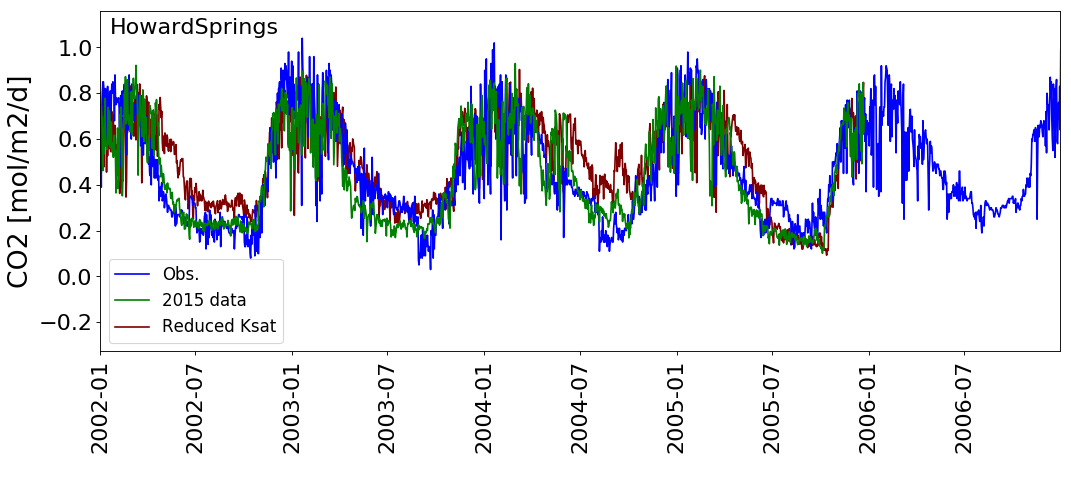

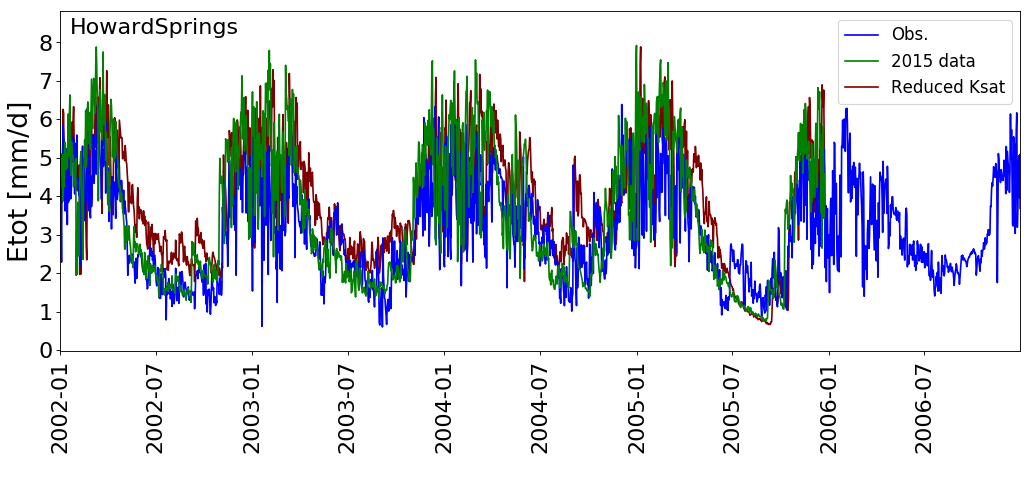

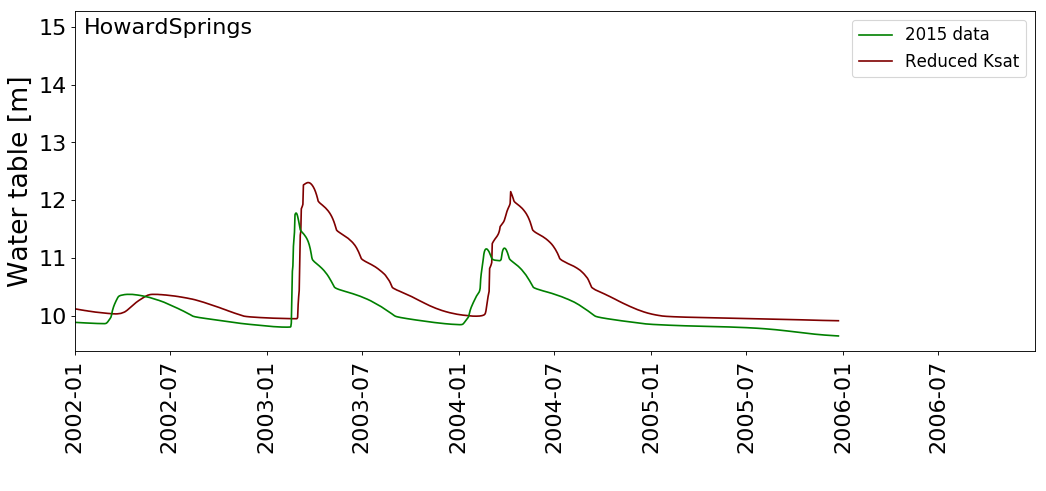

In [13]:
#HowardSprings
%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/12_soil/sce_best/results_daily.txt \
-v asstot --var2015 asstot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/GPPdaily_howard.txt --mf_obs -1 --ylabel "CO2 [mol/m2/d]" \
--labels "Reduced Ksat" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/12_soil/sce_best/results_daily.txt \
-v evaptot --var2015 evaptot -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--obs ../../data/DINGO/Ea_howard.txt --mf 1000 --ylabel "Etot [mm/d]" \
--labels "Reduced Ksat" --title "HowardSprings" --legend True

%run ../../src_py/plot_et_ass.py  \
--i2015 ../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt \
-i ../../data/VOM_output/additional_analyses/comp2015/12_soil/sce_best/results_daily.txt \
-v zw --var2015 ys -ys 2002 -ye 2006 -w ../../data/VOM_input/HowardSprings/dailyweather.prn \
--ylabel "Water table [m]" \
--labels "Reduced Ksat" --title "HowardSprings" --legend True

Reducing the hydraulic conductivity leads to higher values of evaporation and assimilation, which is due to higher groundwater tables.